# Spectral Sounds: Unveiling Music Genre Classification Through Audio Spectrograms

# Introduction:
With the dominance of digital music streaming, music genre classification is an increasingly important way to develop algorithms for suggesting new songs to users. Without a way to analyze the abstract aspects of each song such as mood and tone, these algorithms must be able to make accurate predictions based only on the quantitative characteristics of the audio itself.

Hence, we aim to answer the following research question:
 **Can we predict the genre of a song based on its audio spectrograph information?** In particular, we will focus on the **classical, jazz, pop, and rock music** genres.

### Dataset
We will be using the Music Genre Classification dataset by Andrada on Kaggle. It includes observations for 1000 30-second audio snippets (.wav ), with 60 relevant variables that describe mean and variance values of different aspects of its audio spectrogram (visual waveform) and the corresponding genre of music.


## Preliminary Data Analysis

In [1]:
# Run this first.
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
set.seed(45)

DATASET_URL <- "https://raw.githubusercontent.com/arthu-rguo/dsci-100-proj/master/features_30_sec.csv"
GENRES <- c("classical", "jazz", "pop", "rock")
VARIABLES <- c("chroma_stft_mean", "rms_mean", "spectral_centroid_mean", "spectral_bandwidth_mean", "zero_crossing_rate_mean")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Load and tidy up the dataset.
music_data_raw <- read_csv(DATASET_URL)

music_data <- music_data_raw |>
    select(label, all_of(VARIABLES)) |>
    filter(label %in% GENRES) |>
    relocate(label)

head(music_data)

# Split the dataset into training and testing sets.
music_split <- music_data |> 
    initial_split(props = 0.75, strata = label)

music_training_data <- training(music_split)
music_testing_data <- testing(music_split)

Rows: 1000 Columns: 60
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): filename, label
dbl (58): length, chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spec...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


label,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,zero_crossing_rate_mean
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
classical,0.2523919,0.03624489,1505.166,1559.006,0.09822270
classical,0.2149950,0.03062517,1360.644,1441.243,0.08776563
classical,0.2779581,0.04385955,1490.275,1600.116,0.09004578
classical,0.2342293,0.02944208,1526.630,1499.439,0.10894638
classical,0.2215738,0.04231631,1705.563,1646.064,0.11285717
classical,0.2685303,0.04326224,1431.055,1558.113,0.07521004


In [3]:
# Summarize the training dataset in a table.
music_summary <- music_training_data |>
    group_by(label) |> 
    summarize(count = n(), across(everything(), median))

music_summary

label,count,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,zero_crossing_rate_mean
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
classical,75,0.2572901,0.03321557,1358.547,1525.335,0.07583880
jazz,75,0.2848820,0.07813579,1670.233,1920.377,0.06482661
pop,75,0.3945035,0.20324428,3126.642,3045.880,0.12851842
rock,75,0.3903474,0.12693483,2312.160,2210.479,0.11589710


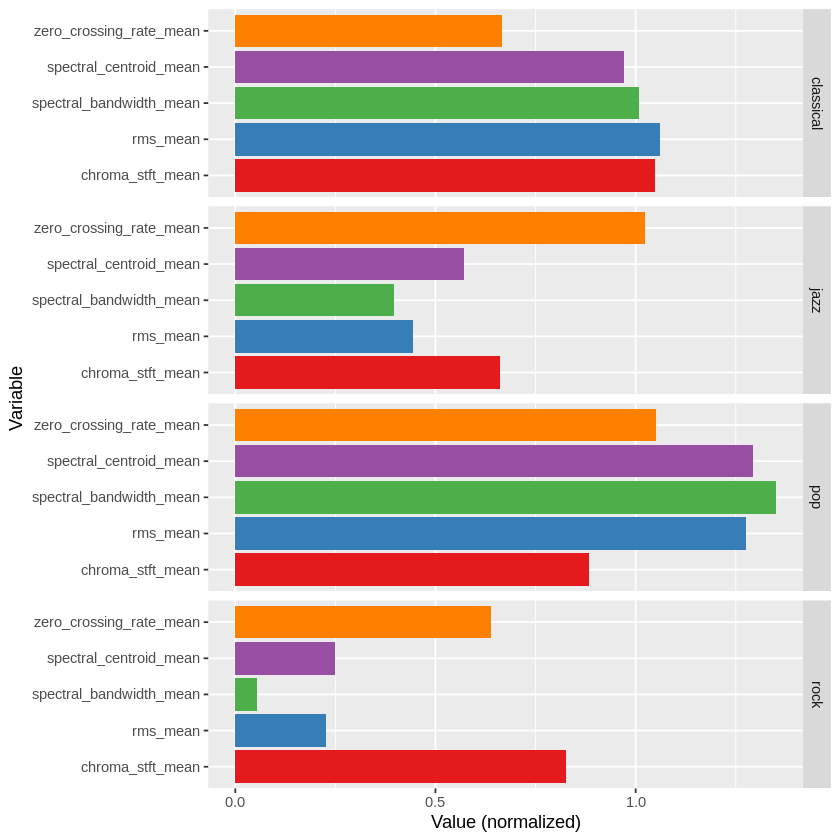

In [4]:
# Visualize the training dataset with a plot.
music_summary_labels <- music_summary |>
    select(label)

music_summary_norms <- music_summary |>
    select(all_of(VARIABLES)) |>
    mutate(across(everything(), scale)) |>
    mutate(across(everything(), abs))

music_summary_long <- bind_cols(music_summary_labels, music_summary_norms) |>
    pivot_longer(cols = -label, names_to = "name", values_to = "value")

music_visualization <- music_summary_long |>
    ggplot(aes(x = name, y = value, fill = name)) +
        geom_bar(stat = "identity") +
        facet_grid(rows = vars(label)) +
        labs(x = "Variable", y = "Value (normalized)") +
        theme(legend.pos = "none") +
        scale_fill_brewer(palette = "Set1") +
        coord_flip()

music_visualization

## Methods

To classify song genre based on audio features, the data will undergo preprocessing, feature extraction, data exploration, data splitting, model training using KNN algorithm, model evaluation, and model optimization. This extracts the relevant features from the audio data to train a KNN model, evaluate its performance, interpret, and report on the ability to classify genre based on audio features.

A few useful predictor variables:

1. **Chroma feature:** Measures the distribution of musical pitch, and captures tonal content. Helpful in distinguishing genres that have distinct harmonic patterns.

2. **RMS (Root Mean Square) values:** Measures the perceived loudness of the signal. Useful in differentiating genres with varying loudness characteristics.

3. **Spectral centroid:** easures the average frequency of the signal. Aids in identifying genres that tend to have specific frequency characteristics.

4. **Spectral bandwidth:** Measures the average spread of frequencies of the signal. Helps differentiate genres with varying spectral width or frequency spread.

5. **Zero crossing rate:** Provides information about the signal's fluctuations. Useful in distinguishing genres with different levels of rhythmic complexity or smoothness.

We also intend to perform iterative predictor variable selection, similar to the technique demonstrated in the textbook.

### Visualization
- **Heatmap:** Visualize the correlation between audio features using a matrix of colors.

- **Scatter plot:** Plot the audio features of songs as data points on a graph to identify clusters or patterns.

- **Box plot:** Illustrate the distribution of audio features within genres using boxes and whiskers.

## Expected Outcomes and Significance

### Expected Findings
Overall, the project anticipates identifying informative and discriminative features that strongly influence genre classification from the audio spectrograph, enabling a deeper understanding of the distinguishing characteristics of different music genres and providing valuable insights in genre classification based on audio features.

### Potential Impacts
Overall, the findings can have practical implications in the music industry and related fields, including enhancing music discovery, improving musical analysis, and assisting music production processes. 


### Future Questions
- How does the performance of KNN classification compare to other algorithms for genre classification?

- How can genre classification models handle songs that contain elements of multiple genres or blur genre boundaries?